In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis,get_time_plate_info_long_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave,plot_single_plate
import matplotlib.patches as mpatches
import statsmodels.api as sm
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.io as sio
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
from scipy.integrate import odeint
import scienceplots
import logging
logging.getLogger().setLevel(logging.WARNING)
%matplotlib widget
%store -r path_figure

plt.style.use('presentation.mplstyle')
# plt.style.use('science')
plates = ['94_20201123']
plate_select = [94]
# plt.rcParams['font.family'] = 'Helvetica'  # Set font family

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
width = 1.6
height = 1

In [3]:
def select_movement(plate_id, time_hypha_info, min_num_occ=1):
    time_hypha_plate = time_hypha_info.loc[time_hypha_info["unique_id"] == plate_id]
    select = time_hypha_plate
    max_speeds = select.groupby("end").max()["speed"]
    correct_tracks = max_speeds.loc[max_speeds <= 450]
    select = select.loc[select["end"].isin(correct_tracks.index)]
    select = select.loc[select["distance_final_pos"] >= 1500]
    select = select.loc[select["speed"].between(50, 400)]
    select = select.loc[select["in_ROI"] == "True"]
    num_occ = select.groupby("end").count()["speed"]
    correct_tracks = num_occ.loc[num_occ >= min_num_occ]
    select = select.loc[select["end"].isin(correct_tracks.index)]
    select_movements = select
    return select_movements


def get_average_time_data(plate_id, time_hypha_info, min_num_occ=1):
    select_movements = select_movement(plate_id, time_hypha_info, min_num_occ)
    group = select_movements.groupby(["time_since_begin_h"])["speed"]
    data = group.median()
    dy = group.std() / np.sqrt(group.count())

    return (data, dy, select_movements)

In [228]:
plates = ['1042_20220523',
       '1045_20220504', '1048_20220506', '1053_20220413'
         ]
# plates += [
# "850_20230511",
# "840_20230404",
# "861_20230411"
# ]
plates += ["527_20230106","537_20230111"]
plates += ["462_20221013"]
plates += ["532_20220104"]
plates += ["28_20230227",
"206_20230303",
"202_20230314",
"218_20230227",
"219_20230307",
"229_20230330",]
plates += ["510_20221201","521_20230104","530_20230115"]
plates += ["771_20230411","772_20230317"]
plates += [
    "896_20230424",
    "894_20230516",
    "891_20230519",
    "886_20230516",
    "870_20230427",
    "868_20230504",
    "796_20230419",
    "795_20230403",
    "764_20221219",
]
plates += [
        "559_20230109", 

          "544_20230109",
          "531_20221222",
]
plates += [
         "514_20221206",
         "513_20221205",
         "506_20221124",
         "472_20221003"
          ]
plates += [
          "558_20230109",
          "552_20230111",
          "551_20220102",
          "540_20221227",
]
all_analysis_folders = get_analysis_folders()
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]


In [250]:
folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders)

In [251]:
time_hypha_info['unique_hypha']=time_hypha_info["end"].astype(int).astype(str)+"_"+time_hypha_info["unique_id"].astype(str)


In [252]:
min_num_occ = 30
max_speeds = time_hypha_info.groupby("unique_hypha").max()["speed"]
correct_tracks = max_speeds.loc[max_speeds <= 450]
select = time_hypha_info.loc[time_hypha_info["unique_hypha"].isin(correct_tracks.index)]
select = select.loc[select["distance_final_pos"] >= 400]
select = select.loc[select["speed"].between(80, 400)]
select = select.loc[select["in_ROI"] == "True"]
num_occ = select.groupby("unique_hypha").count()["speed"]
correct_tracks = num_occ.loc[num_occ >= min_num_occ]
select = select.loc[select["unique_hypha"].isin(correct_tracks.index)]
len(select["unique_hypha"].unique())

345

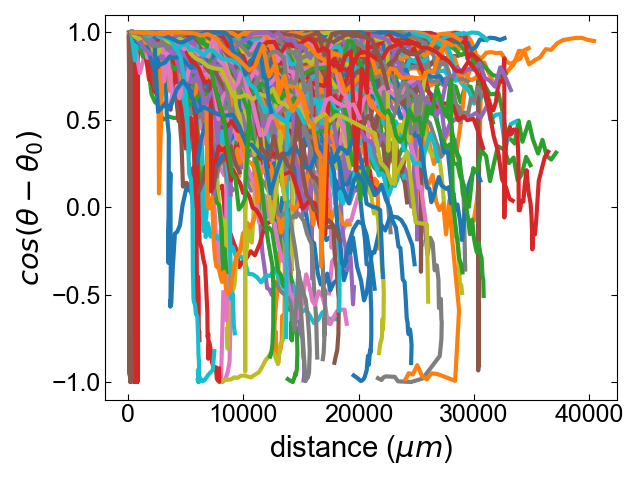

In [395]:
select_movements = select
fig,ax = plt.subplots()
select_hyphae = select_movements.loc[select_movements['timestep']<100]

select_hyphae = select_movements.loc[select_movements['speed']>200].copy()
vecs_lists = []    
# for j,hyph in enumerate([0,  118, 58, 1]):
i = 0
begin = 0
for j,hyph in enumerate(select_hyphae['unique_hypha'].unique()[begin:]):
    select_hypha = select_movements.loc[select_movements['unique_hypha']==hyph]
#     select_hypha = select_hypha.loc[select_hypha['timestep']<100]
    
#     select_hypha = select_hypha.loc[select_hypha['speed']>200].copy()
    

    select_hypha = select_hypha.sort_values('timestep')
    vecx,vecy = select_hypha['pos_x'].diff(1),select_hypha['pos_y'].diff(1)
    vecx_norm = vecx/(vecx**2+vecy**2)**(1/2)
    vecy_norm = vecy/(vecx**2+vecy**2)**(1/2)
    persistence = vecx_norm.iloc[1]*vecx_norm+vecy_norm.iloc[1]*vecy_norm
    dists = np.sqrt((select_hypha['pos_x']-select_hypha['pos_x'].iloc[0])**2+(select_hypha['pos_y']-select_hypha['pos_y'].iloc[0])**2)*1.725
    vecs_lists.append((dists.values,vecx_norm.iloc[1:].values,vecy_norm.iloc[1:].values))
    ax.plot(dists,persistence,alpha=1)
    i+=1
    # if i>5:
    #     break
ax.set_xlabel('distance ($\mu m$)')
ax.set_ylabel(r'$cos(\theta-\theta_0)$')
plt.tight_layout()

In [255]:
len(select_movements)

15002

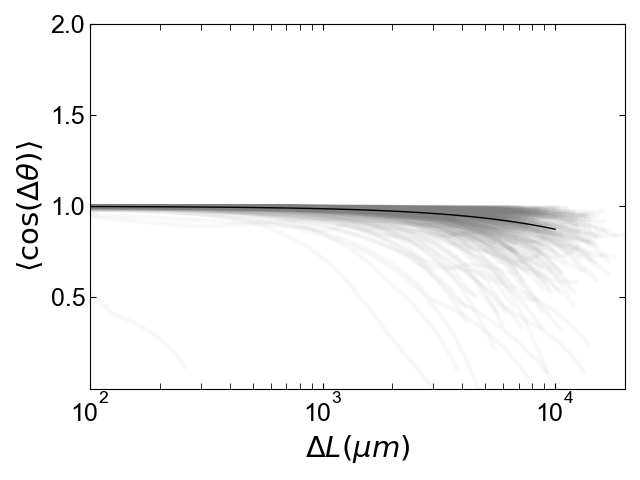

In [397]:
# fig,ax = plt.subplots(figsize=(width,height))
fig,ax = plt.subplots()

correlation_length = []
for k in range(len(vecs_lists)):
    dist = vecs_lists[k][0][1:]
    vecx = vecs_lists[k][1]
    vecy = vecs_lists[k][2]
    if len(vecx)>4:
        # Generate new regularly spaced x
        new_dist = np.linspace(start=dist.min(), stop=dist.max(), num=100)  # for instance, 100 points

        # Interpolate y values at new x
        new_vecx = np.cos(np.interp(new_dist, dist, np.arccos(vecx)))

        # Interpolate y values at new x
        new_vecy = np.sin(np.interp(new_dist, dist, np.arcsin(vecy)))

        correlation_func = np.zeros(len(new_vecx))
        
        # Compute the correlation function
        for i in range(len(new_vecx)):
            for j in range(i, len(new_vecx)):
                # Compute the cosine of the angle between the tangents
                cos_theta = new_vecx[i]*new_vecx[j]+new_vecy[i]*new_vecy[j]
                # Add to the correlation function
                correlation_func[j-i] += cos_theta

        # Average the correlation function
        correlation_func /= np.arange(len(new_vecx), 0, -1)
        if not np.any(np.isnan(correlation_func)):
            popt, pcov = curve_fit(exp_func,new_dist[:len(new_vecx)//2]-new_dist[0], correlation_func[:len(new_vecx)//2],p0=[5000])
            correlation_length.append(popt[0])
            ax.plot(new_dist[:len(new_vecx)//2]-new_dist[0],correlation_func[:len(new_vecx)//2],color="grey",alpha = 0.05)
            xs = new_dist[:len(new_vecx)//2]-new_dist[0]
        # ax.plot(xs,np.exp(-xs/popt[0]))        
        # break
ax.set_xscale("log")
# ax.set_yscale("log")

xs = np.linspace(1e1,1e4,100)
ax.set_xlim(1e2,2e4)
ax.set_ylim(1e-4,2)

ax.plot(xs,np.exp(-xs/np.median(correlation_length)),color="black",linewidth=1)
ax.set_xlabel('$\Delta L(\mu m)$')
ax.set_ylabel('$\\langle \\cos(\Delta \\theta) \\rangle$')
plt.tight_layout()

In [398]:
np.median(correlation_length)

74492.23686001808

In [132]:
def exp_func(x, a):
    return np.exp(-x / a)

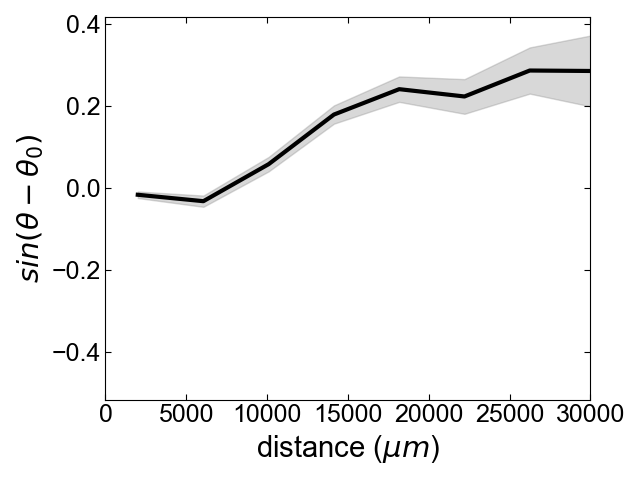

In [404]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# select_hyphae = select_movements.loc[select_movements['speed'] > 200].copy()
# df = pd.DataFrame(columns=["distance", "persistence", "hyph_id"])

# for j, hyph in enumerate(select_hyphae['unique_hypha'].unique()):
#     select_hypha = select_movements.loc[select_movements['unique_hypha'] == hyph]
#     select_hypha = select_hypha.sort_values('timestep')
#     vecx, vecy = select_hypha['pos_x'].diff(1), select_hypha['pos_y'].diff(1)
#     vecx_norm = vecx / (vecx**2 + vecy**2)**(1/2)
#     vecy_norm = vecy / (vecx**2 + vecy**2)**(1/2)
#     persistence = vecx_norm.iloc[1]*vecy_norm - vecy_norm.iloc[1]*vecx_norm
#     dists = np.sqrt((select_hypha['pos_x'] - select_hypha['pos_x'].iloc[0])**2 + (select_hypha['pos_y'] - select_hypha['pos_y'].iloc[0])**2) * 1.725
#     temp_df = pd.DataFrame({
#         "distance": dists.values,
#         "persistence": persistence.values,
#         "hyph_id": [hyph] * len(dists)
#     })
#     df = pd.concat([df, temp_df])
    # ax.plot(dists, persistence, color="grey", alpha=0.05)

ax.set_xlabel('distance ($\mu m$)')
ax.set_ylabel(r'$sin(\theta-\theta_0)$')
df = df.sort_values(by='distance')

# Bin the 'distance' data into 10 equal intervals
df['bin'] = pd.cut(df['distance'], bins=10)
bin_avg = df.groupby('bin')['persistence'].mean()
bin_sem = df.groupby('bin')['persistence'].sem()

# Compute the 95% confidence intervals
conf_intervals = 1.96 * bin_sem
lower_bound = bin_avg - conf_intervals
upper_bound = bin_avg + conf_intervals

# Plot the binned persistence against the middle of each distance bin with the confidence interval
bin_centers = [interval.mid for interval in bin_avg.index]
ax.plot(bin_centers, bin_avg.values, color="black", label="Binned Avg")
ax.fill_between(bin_centers, lower_bound, upper_bound, color="grey", alpha=0.3)

# Add legend
# ax.legend()
ax.set_xlim(0,30000)
plt.tight_layout()


In [300]:
import pandas as pd

# List to store individual DataFrames for each hyph
dfs = []
select_hyphae = select_movements.loc[select_movements['speed']>200].copy()

for j, hyph in enumerate(select_hyphae['unique_hypha'].unique()):
    select_hypha = select_hyphae.loc[select_hyphae['unique_hypha'] == hyph]
    select_hypha = select_hypha.sort_values('timestep')
    
    # Extract signal and x values
    signal = (select_hypha['speed'].values-np.mean(select_hypha['speed']))/np.std(select_hypha['speed'])
    time_day = select_hypha['datetime'].dt.time.values
    time_since_begin = select_hypha['time_since_begin_h'].values
    

    # Create a temporary DataFrame for this hyph
    temp_df = pd.DataFrame({
        'time_day': time_day,
        'time_since_begin': time_since_begin,
        'signal': signal,
        'pos_x': select_hypha['pos_x'].values,
        'pos_y': select_hypha['pos_y'].values,
        'hyph': [hyph] * len(time_day),  # Optionally record the hyph value for reference
        'unique_id' : [select_hypha['unique_id'].iloc[0]]* len(time_day)
    })
    
    # Append this DataFrame to the list
    dfs.append(temp_df)

# Concatenate all the individual DataFrames into one
final_df = pd.concat(dfs, ignore_index=True)


C:\Users\coren\AppData\Local\Temp\ipykernel_22084\916319051.py:12: RuntimeWarning: invalid value encountered in divide
  signal = (select_hypha['speed'].values-np.mean(select_hypha['speed']))/np.std(select_hypha['speed'])


In [301]:
final_df

,time_day,time_since_begin,signal,pos_x,pos_y,hyph,unique_id
0,13:14:00,0 days 00:00:00,-0.153707,20158.0,19064.0,569_104220220523,104220220523
1,15:14:00,0 days 02:00:00,-0.275485,20013.0,19308.0,569_104220220523,104220220523
2,17:28:00,0 days 04:14:00,-0.104642,19836.0,19563.0,569_104220220523,104220220523
3,20:04:00,0 days 06:50:00,0.510695,19618.0,19859.0,569_104220220523,104220220523
4,22:04:00,0 days 08:50:00,-0.843257,19445.0,20107.0,569_104220220523,104220220523
...,...,...,...,...,...,...,...
10868,08:55:00,6 days 18:17:00,-1.228286,19939.0,23968.0,216759_89420230516,89420230516
10869,12:09:00,6 days 21:31:00,-1.378333,20171.0,23615.0,216759_89420230516,89420230516
10870,14:08:00,6 days 23:30:00,-1.685963,20313.0,23403.0,216759_89420230516,89420230516
10871,16:38:00,7 days 02:00:00,-0.867320,20525.0,23180.0,216759_89420230516,89420230516


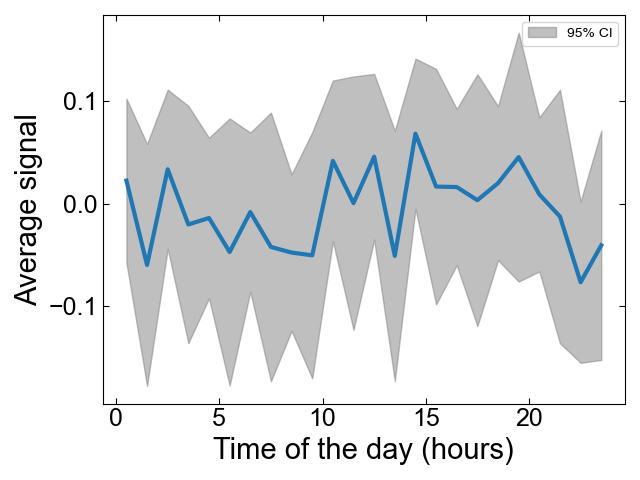

In [377]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ... [Your code that creates the final_df DataFrame]

# Convert time objects to timedelta
final_df['time_delta'] = pd.to_timedelta(final_df['time_day'].astype(str))

# Define bin edges as one-hour intervals
bin_edges = pd.timedelta_range(start='0 hours', end='24 hours', freq='1H')

# Create one-hour bins
final_df['time_bins'] = pd.cut(final_df['time_delta'], bins=bin_edges)

# Compute average speed for each bin
binned_avg = final_df.groupby('time_bins')['signal'].mean()

# Compute standard error for each bin
stderr = final_df.groupby('time_bins')['signal'].sem()

# Compute upper and lower bounds for 95% confidence interval
confidence_interval = 1.96 * stderr  # For 95% CI with a normal distribution
upper_bound = binned_avg + confidence_interval
lower_bound = binned_avg - confidence_interval

# Plot
fig, ax = plt.subplots()
mid_points = [(interval.left + interval.right) / 2 for interval in binned_avg.index]
mid_points_in_hours = [point.total_seconds() / 3600 for point in mid_points]  # Convert to hours for better readability
ax.plot(mid_points_in_hours, binned_avg)
ax.fill_between(mid_points_in_hours, lower_bound, upper_bound, color='grey', alpha=0.5, label='95% CI')

ax.set_xlabel('Time of the day (hours)')
ax.set_ylabel('Average signal')
# ax.set_title('Binned Average of Speed vs Time with 95% CI')
ax.legend()
plt.tight_layout()
plt.show()


In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
# Convert 'time_since_begin' to a timedelta type and set it as the index for resampling
final_df['time_since_begin_timedelta'] = pd.to_timedelta(final_df['time_since_begin'])
final_df.set_index('time_since_begin_timedelta', inplace=True)

# Function to compute autocorrelation
def compute_autocorr(series, lags):
    return [series.autocorr(lag=lag) for lag in lags]

autocorr_list = []
lag_list = []
for hyph in final_df['hyph'].unique():
    hyph_df = final_df[final_df['hyph'] == hyph]
    
    # Resample to 2 hours and interpolate to fill missing values
    resampled = hyph_df['signal'].resample('2H').mean().interpolate()
    lag_range = range(len(resampled)//2)  # Adjust as per your data
    # Compute autocorrelation for this hyph
    with warnings.catch_warnings():
        warnings.simplefilter("error", RuntimeWarning)
        try:
            # Compute autocorrelation for this hyph
            autocorr_values = compute_autocorr(resampled, lag_range)
            autocorr_list+= autocorr_values
            lag_list+= lag_range
        except RuntimeWarning as e:
            print(f"Error encountered for hyph: {hyph}")
            print("Error message:", e)    
            break

# Convert list to DataFrame for easier processing
autocorr_df = pd.DataFrame(list(zip(autocorr_list,lag_list)), columns=['autocor','lag'])

# Compute mean and standard error for plotting
mean_autocorr = autocorr_df.groupby('lag').mean()
stderr_autocorr = autocorr_df.groupby('lag').sem()



In [121]:
mean_autocorr.index.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60], dtype=int64)

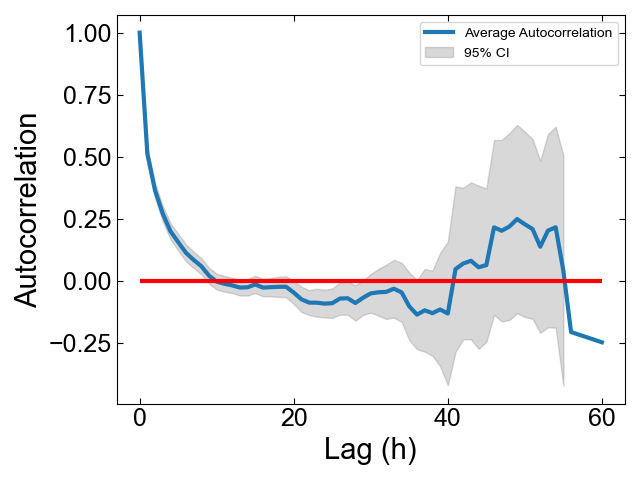

In [379]:
# Plotting
fig, ax = plt.subplots()
ax.plot(mean_autocorr.index,mean_autocorr.values, label='Average Autocorrelation')
y1 = np.ravel(mean_autocorr.values - 1.96*stderr_autocorr.values)
y2 = np.ravel(mean_autocorr.values + 1.96*stderr_autocorr.values)
ax.fill_between(np.ravel(mean_autocorr.index.values), y1, y2, color='gray', alpha=0.3, label='95% CI')
ax.set_xlabel('Lag (h)')
ax.set_ylabel('Autocorrelation')
ax.hlines(0,0,60,color="red")
ax.legend()
plt.tight_layout()


In [142]:
final_df

,time_day,time_since_begin,signal,hyph,unique_id
time_since_begin,,,,,
0 days 00:00:00,13:14:00,0 days 00:00:00,-0.153707,569_104220220523,104220220523
0 days 02:00:00,15:14:00,0 days 02:00:00,-0.275485,569_104220220523,104220220523
0 days 04:14:00,17:28:00,0 days 04:14:00,-0.104642,569_104220220523,104220220523
0 days 06:50:00,20:04:00,0 days 06:50:00,0.510695,569_104220220523,104220220523
0 days 08:50:00,22:04:00,0 days 08:50:00,-0.843257,569_104220220523,104220220523
...,...,...,...,...,...
6 days 18:17:00,08:55:00,6 days 18:17:00,-1.228286,216759_89420230516,89420230516
6 days 21:31:00,12:09:00,6 days 21:31:00,-1.378333,216759_89420230516,89420230516
6 days 23:30:00,14:08:00,6 days 23:30:00,-1.685963,216759_89420230516,89420230516


In [303]:
final_df['time_since_begin_timedelta'] = pd.to_timedelta(final_df['time_since_begin'])

# Resampling
dfs = []

for hyph, group in final_df.groupby('hyph'):
    group = group.set_index('time_since_begin_timedelta')
    resampled_group = group.resample('2H').mean(numeric_only=True).interpolate()
    resampled_group['hyph'] = hyph
    dfs.append(resampled_group)

resampled_df = pd.concat(dfs).reset_index()

# Cleaning up the dataframe (removing NaNs introduced by resampling and interpolation)
resampled_df = resampled_df.dropna(subset=['signal'])
resampled_df['time_since_begin_timedelta'] = resampled_df['time_since_begin_timedelta'].dt.round('H')

In [304]:
resampled_df

,time_since_begin_timedelta,signal,pos_x,pos_y,unique_id,hyph
0,0 days 20:00:00,-0.903479,21779.0,38848.0,5.132022e+10,1015666_51320221205
1,0 days 22:00:00,-0.509096,21581.0,38708.0,5.132022e+10,1015666_51320221205
2,1 days 00:00:00,0.510338,21171.0,38520.0,5.132022e+10,1015666_51320221205
3,1 days 02:00:00,0.010805,20886.0,38456.0,5.132022e+10,1015666_51320221205
4,1 days 04:00:00,-0.522199,20623.0,38382.0,5.132022e+10,1015666_51320221205
...,...,...,...,...,...,...
14102,3 days 08:00:00,0.259244,21483.5,19006.0,2.820230e+09,98460_2820230227
14103,3 days 10:00:00,-0.696398,21515.0,18820.0,2.820230e+09,98460_2820230227
14104,3 days 12:00:00,1.098628,21553.0,18589.0,2.820230e+09,98460_2820230227
14105,3 days 14:00:00,0.499714,21588.0,18361.0,2.820230e+09,98460_2820230227


In [357]:
result_data = []

# Group by unique_id
for unique_id, group in resampled_df.groupby('unique_id'):
    hyphs = group['hyph'].unique()
    
    # Compare each signal to every other signal
    for i in range(len(hyphs)):
        for j in range(i+1, len(hyphs)):
            hyph_i = group[group['hyph'] == hyphs[i]].set_index('time_since_begin_timedelta')['signal']
            hyph_j = group[group['hyph'] == hyphs[j]].set_index('time_since_begin_timedelta')['signal']

            # Only compare signals over shared time intervals
            common_index = hyph_i.index.intersection(hyph_j.index)
            if len(common_index) < 2:  # At least two points are required to compute correlation
                continue
            corr_value = hyph_i[common_index].corr(hyph_j[common_index])
            xi = group[group['hyph'] == hyphs[i]].set_index('time_since_begin_timedelta')['pos_x']
            yi = group[group['hyph'] == hyphs[i]].set_index('time_since_begin_timedelta')['pos_y']
            xj = group[group['hyph'] == hyphs[j]].set_index('time_since_begin_timedelta')['pos_x']
            yj = group[group['hyph'] == hyphs[j]].set_index('time_since_begin_timedelta')['pos_y']
            dist = (xi-xj)**2
            dist += (yi-yj)**2
            mean_dist = np.mean(np.sqrt(dist))
            init_dist = np.sqrt(dist)[1]
            result_data.append({
                'plate': unique_id,
                'corr_value': corr_value,
                'init_dist': init_dist,
                'mean_dist': mean_dist,
                'shuffled' : False
            })    
df = pd.DataFrame(result_data)


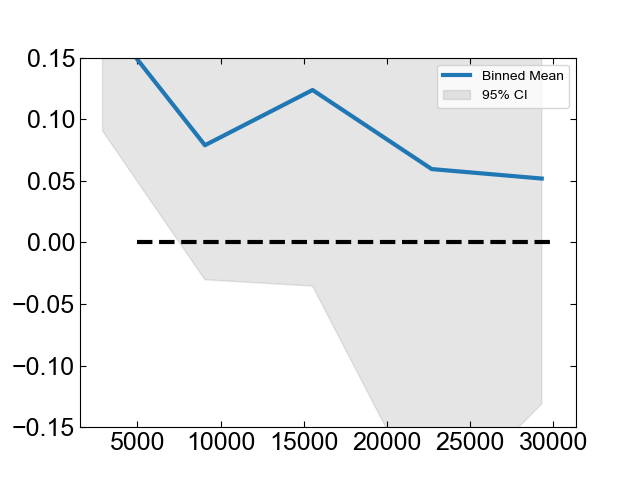

In [361]:
df = df.sort_values(by="init_dist")

# Define number of bins
k = 5

# Create bins for the mean_dist values
df['bin'] = pd.cut(df['init_dist'], bins=k, labels=False)

# Group by bins and compute statistics for each bin
bin_stats = df.groupby('bin').agg(
    mean_dist_center=('init_dist', 'mean'),
    mean_corr=('corr_value', 'mean'),
    std_corr=('corr_value', 'std'),
    count=('corr_value', 'count')
)

# Compute the 2.5th and 97.5th percentiles for each bin
bin_stats['lower_bound'] = bin_stats['mean_corr'] - 2*bin_stats['std_corr']/np.sqrt(bin_stats['count'])
bin_stats['upper_bound'] = bin_stats['mean_corr'] + 2*bin_stats['std_corr']/np.sqrt(bin_stats['count'])

# Plot
fig, ax = plt.subplots()
# ax.scatter(df['mean_dist'], df['corr_value'], label='Data', s=1)
ax.plot(bin_stats['mean_dist_center'], bin_stats['mean_corr'], label='Binned Mean')
ax.fill_between(bin_stats['mean_dist_center'], bin_stats['lower_bound'], bin_stats['upper_bound'], color='grey', alpha=0.2, label='95% CI')
ax.set_ylim(-0.15,0.15)
ax.hlines(0,5000,30000,color = "black",linestyle="dashed")
ax.legend()
ax.set_xlabel("")
ax.set_ylabel("")

plt.show()

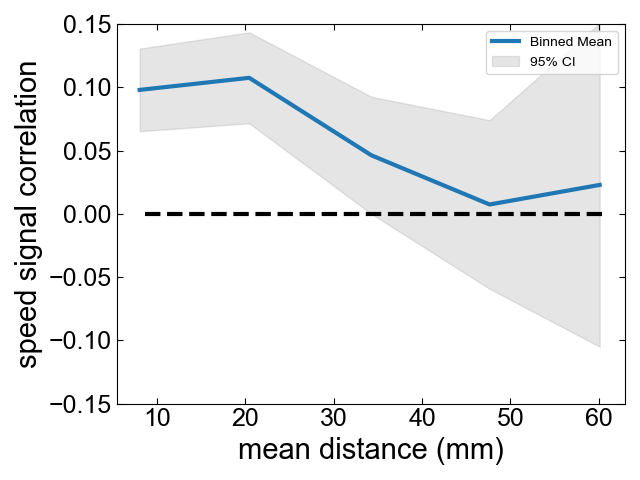

In [367]:
df = df.sort_values(by="mean_dist")

# Define number of bins
k = 5

# Create bins for the mean_dist values
df['bin'] = pd.cut(df['mean_dist'], bins=k, labels=False)

# Group by bins and compute statistics for each bin
bin_stats = df.groupby('bin').agg(
    mean_dist_center=('mean_dist', 'mean'),
    mean_corr=('corr_value', 'mean'),
    std_corr=('corr_value', 'std'),
    count=('corr_value', 'count')
)

# Compute the 2.5th and 97.5th percentiles for each bin
bin_stats['lower_bound'] = bin_stats['mean_corr'] - 2*bin_stats['std_corr']/np.sqrt(bin_stats['count'])
bin_stats['upper_bound'] = bin_stats['mean_corr'] + 2*bin_stats['std_corr']/np.sqrt(bin_stats['count'])

# Plot
fig, ax = plt.subplots()
# ax.scatter(df['mean_dist'], df['corr_value'], label='Data', s=1)
ax.plot(bin_stats['mean_dist_center']*1.725/1000, bin_stats['mean_corr'], label='Binned Mean')
ax.fill_between(bin_stats['mean_dist_center']*1.725/1000, bin_stats['lower_bound'], bin_stats['upper_bound'], color='grey', alpha=0.2, label='95% CI')
ax.set_ylim(-0.15,0.15)
ax.hlines(0,5*1.725,35*1.725,color = "black",linestyle="dashed")
ax.legend()
ax.set_xlabel("mean distance (mm)")
ax.set_ylabel("speed signal correlation")
plt.tight_layout()


In [368]:
len(df)

1190

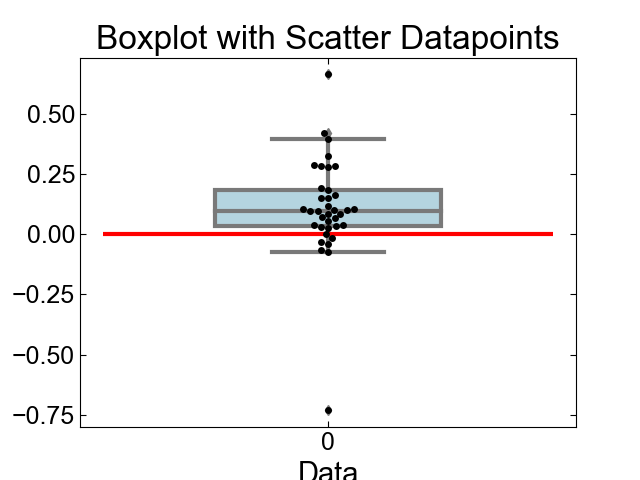

In [277]:
fig,ax = plt.subplots()
data = correlations
sns.boxplot(data=data, color="lightblue", width=0.3)

# Overlay the scatter datapoints
sns.swarmplot(data=data, color="black", size=5)

plt.title("Boxplot with Scatter Datapoints")
plt.xlabel("Data")
ax.hlines(0,-0.3,0.3,color="red")

plt.show()

In [162]:
import numpy as np

def compute_avg_corr(group1, group2):
    hyphs1 = group1['hyph'].unique()
    hyphs2 = group2['hyph'].unique()
    correlations = []

    for hyph1 in hyphs1:
        for hyph2 in hyphs2:
            signal1 = group1[group1['hyph'] == hyph1].set_index('time_since_begin_timedelta')['signal']
            signal2 = group2[group2['hyph'] == hyph2].set_index('time_since_begin_timedelta')['signal']

            common_index = signal1.index.intersection(signal2.index)
            if len(common_index) < 2:  # At least two points required for correlation
                continue
            corr_value = signal1[common_index].corr(signal2[common_index])
            if np.isnan(corr_value):
                continue
            correlations.append(corr_value)

    if correlations:
        return sum(correlations) / len(correlations)
    return None


correlation_results = []
unique_ids = resampled_df['unique_id'].unique()

for reference_id in unique_ids:
    reference_group = resampled_df[resampled_df['unique_id'] == reference_id]

    for other_id in unique_ids:
        if reference_id == other_id:
            continue
        other_group = resampled_df[resampled_df['unique_id'] == other_id]

        avg_corr = compute_avg_corr(reference_group, other_group)
        if avg_corr is not None:
            correlation_results.append({
                'Reference Plate': reference_id,
                'Other Plate': other_id,
                'Average Correlation': avg_corr
            })

correlation_df = pd.DataFrame(correlation_results)


In [164]:
np.mean(correlation_df['Average Correlation'])

-0.009876454643352354

In [278]:
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,False)
time_plate_info['datetime'] = pd.to_datetime(time_plate_info['date'], format='%d.%m.%Y, %H:%M:')

In [230]:
len(analysis_folders)

39

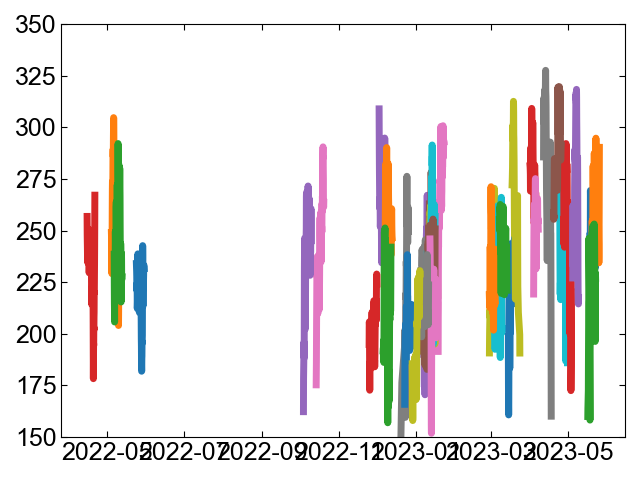

In [279]:
from scipy.signal import savgol_filter
ncols = 2

fig,ax = plt.subplots()


i = 0
for k,plate in enumerate(plates):

    select_plate = select[select['unique_id']==int(plate)]
    select_plate_time = time_plate_info[time_plate_info['unique_id']==int(plate)]
    select_plate_time = select_plate_time[select_plate_time['time_since_begin_h']<=150]
    select_plate_time = select_plate_time[select_plate_time['hull_speed']>0]
    
    speed_data = select_plate_time['hull_speed'] 
    if len(speed_data) >=9:
        i+=1
        smoothed_speed = savgol_filter(speed_data, window_length=7, polyorder=2)            
        x = pd.to_datetime(select_plate_time['date'], format='%d.%m.%Y, %H:%M:')
        ax.plot(x,smoothed_speed,linewidth = 5)

        ax.set_ylim(150,350)
    # ax.hlines(300,0,150)
    # ax.set_xlim(0,150)
    # break
plt.tight_layout()

In [411]:
min_num_occ = 30
max_speeds = time_hypha_info.groupby("unique_hypha").max()["speed"]
correct_tracks = max_speeds.loc[max_speeds <= 450]
select = time_hypha_info.loc[time_hypha_info["unique_hypha"].isin(correct_tracks.index)]
select = select.loc[select["distance_final_pos"] >= 400]
select = select.loc[select["speed"].between(80, 400)]
select = select.loc[select["in_ROI"] == "True"]
num_occ = select.groupby("unique_hypha").count()["speed"]
correct_tracks = num_occ.loc[num_occ >= min_num_occ]
select = select.loc[select["unique_hypha"].isin(correct_tracks.index)]
len(select["unique_hypha"].unique())

345

In [286]:
timestep = {32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 65,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:150,152:35,792:60,1048:60,1045:50,941:50}
timestep2 = {102:25,83:70,76:20,81:70,32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 75,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:100,152:35,792:50,1048:60,1045:50}
timestep = {**timestep, **timestep2}
timestep2 = {1014 : 80,1024:25,1027:18,1028:60,1030 : 60,1032 : 50,1042 : 120,1048:70,127:120,129:60,130:50,991:40}
timestep = {**timestep, **timestep2}
timestep2 = {1023 : 60,1031:30,1035:30,1037 : 80,1039 : 90,1045:70,1047:50,1053:40}
timestep = {**timestep, **timestep2}    

timestep2 = {1071 : 25,1076:70,839:60,938 : 35}
timestep = {**timestep, **timestep2}
timestep2 = {30 : 62,32 : 160,33:80}
timestep = {**timestep, **timestep2}
timestep2 = {799 : 100,800 : 25,91:100,99:40}
timestep = {**timestep, **timestep2}
timestep2 = {3:144,16 : 39, 12:70,480:150,28 : 100}
timestep = {**timestep, **timestep2}
timestep2 = {3:144,16 : 39, 12:70,480:150,28 : 100,206 : 90,202 : 100,218 : 100,219 :100,229 :100}
timestep = {**timestep, **timestep2}
for j in range(0,len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    if not plate in timestep.keys():
        timestep[plate] = 100

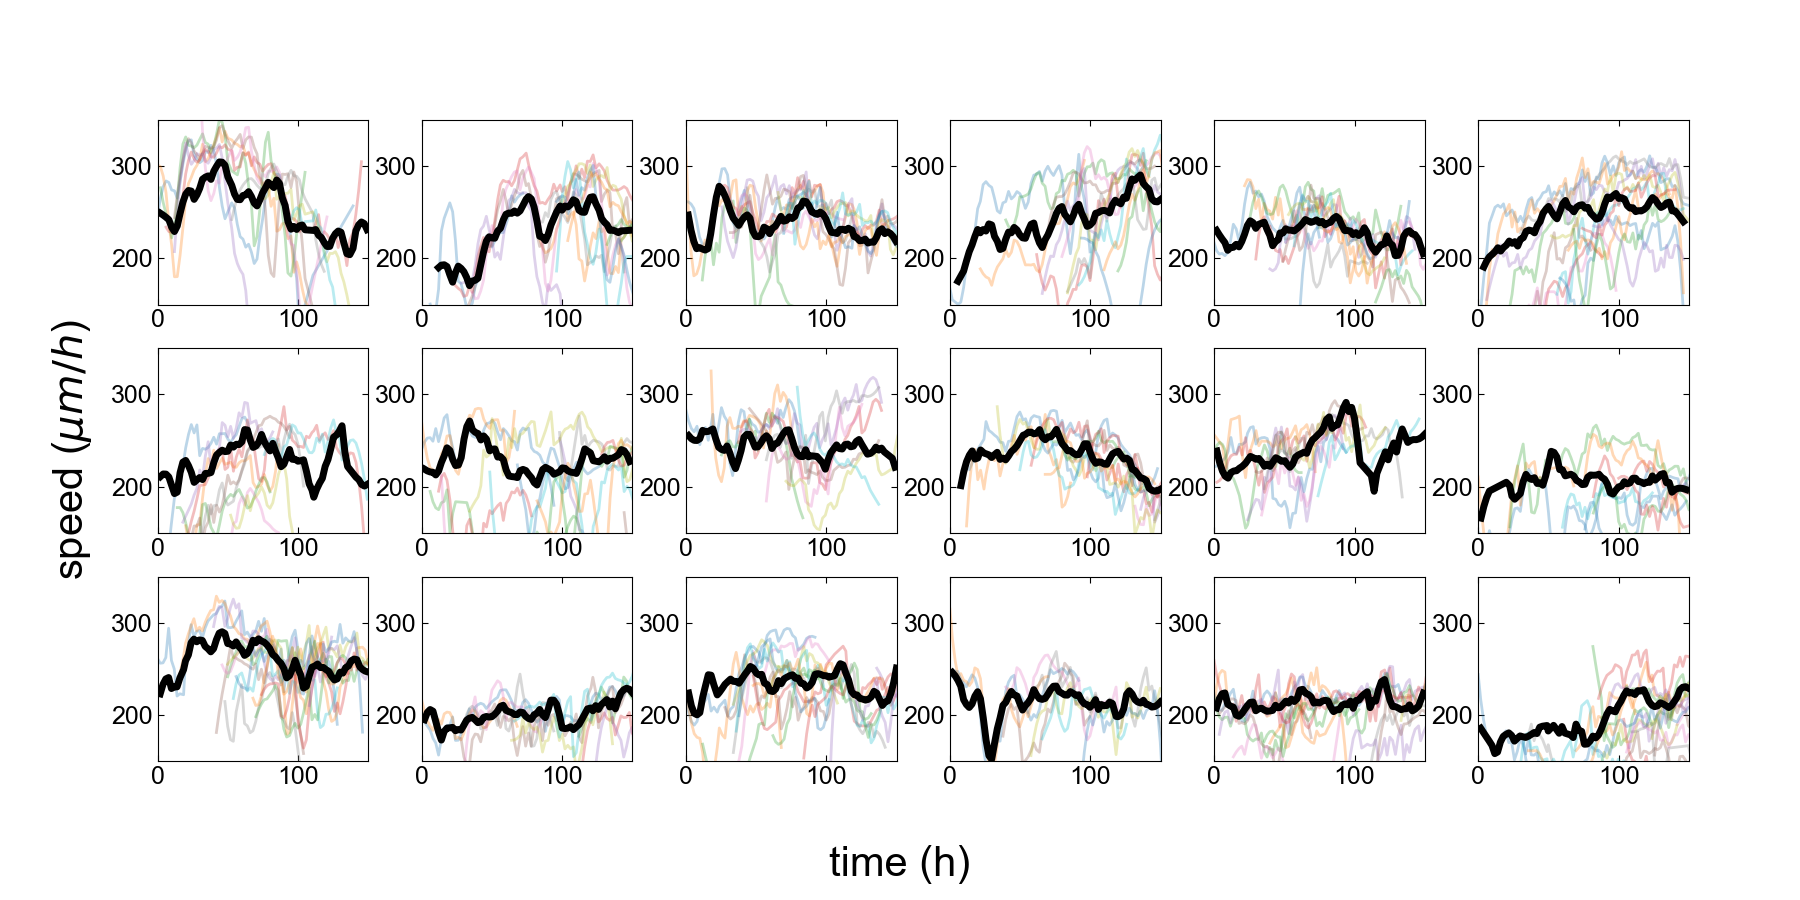

In [336]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import numpy as np

ncols = 6

# Determine number of required rows for subplots based on the length of plates and ncols

plates_interest = []

for k, plate in enumerate(plates):
    select_plate = select[select['unique_id']==int(plate)]
    if len(select_plate['unique_hypha'].unique())>=10:
        plates_interest.append(plate)
nrows = int(np.ceil(len(plates_interest) / ncols))
if nrows == 1:
    axs = np.reshape(axs, (1, -1))
i = 0
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))

# If only one row is needed, make sure axs is still a 2D array for consistency

for k, plate in enumerate(plates_interest):

    ax = axs[i // ncols, i % ncols]  # Choose the appropriate subplot
    select_plate = select[select['unique_id']==int(plate)]
    for hyph in select_plate['unique_hypha'].unique():
        select_hyph = select[select['unique_hypha']==hyph]
        select_hyph = select_hyph[select_hyph['timestep']<=timestep[int(plate.split('_')[0])]]

        select_hyph = select_hyph.sort_values('time_since_emergence')
        time_data = select_hyph['time_since_begin_exp']
        speed_data = select_hyph['speed']
        # Apply Savitzky-Golay smoothing to the speed data
        if len(speed_data) >=9:
            smoothed_speed = savgol_filter(speed_data, window_length=7, polyorder=2)            
            ax.plot(time_data, smoothed_speed,alpha = 0.3,linewidth = 2)
    select_plate_time = time_plate_info[time_plate_info['unique_id'] == int(plate)]
    select_plate_time = select_plate_time[select_plate_time['time_since_begin_h'] <= 150]
    select_plate_time = select_plate_time[select_plate_time['hull_speed'] > 0]
    
    speed_data = select_plate_time['hull_speed']
    if len(speed_data) >= 9:
        i += 1
        smoothed_speed = savgol_filter(speed_data, window_length=7, polyorder=2)
        x = select_plate_time['time_since_begin_h']
        ax.plot(x, smoothed_speed, linewidth=5,color="black")
    ax.set_ylim(150, 350)
    ax.set_xlim(0, 150)
    # break

        # Optionally, set titles or other properties for each subplot
        # ax.set_title(f"Plate {plate}")

    # # Hide any unused subplots if there are any
    # for j in range(i, nrows * ncols):
    #     axs[j // ncols, j % ncols].axis('off')
plt.tight_layout(pad = 8,h_pad = 0.5,w_pad =0.5)

fig.text(0.5, 0.04, 'time (h)', ha='center', va='center', fontsize=30)
fig.text(0.04, 0.5, 'speed ($\mu m/h$)', ha='center', va='center', rotation='vertical', fontsize=30)

plt.show()


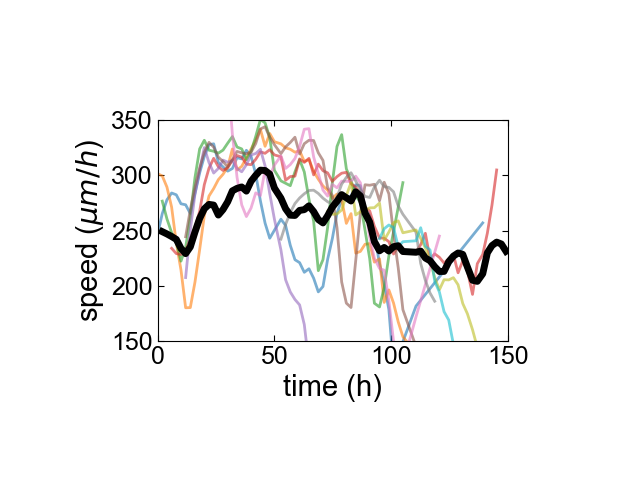

In [348]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import numpy as np

ncols = 6

# Determine number of required rows for subplots based on the length of plates and ncols

plates_interest = []

for k, plate in enumerate(plates):
    select_plate = select[select['unique_id']==int(plate)]
    if len(select_plate['unique_hypha'].unique())>=10:
        plates_interest.append(plate)
nrows = int(np.ceil(len(plates_interest) / ncols))
if nrows == 1:
    axs = np.reshape(axs, (1, -1))
i = 0
fig, ax = plt.subplots()

# If only one row is needed, make sure axs is still a 2D array for consistency

for k, plate in enumerate(plates_interest[:1]):

    select_plate = select[select['unique_id']==int(plate)]
    for hyph in select_plate['unique_hypha'].unique():
        select_hyph = select[select['unique_hypha']==hyph]
        select_hyph = select_hyph[select_hyph['timestep']<=timestep[int(plate.split('_')[0])]]

        select_hyph = select_hyph.sort_values('time_since_emergence')
        time_data = select_hyph['time_since_begin_exp']
        speed_data = select_hyph['speed']
        # Apply Savitzky-Golay smoothing to the speed data
        if len(speed_data) >=9:
            smoothed_speed = savgol_filter(speed_data, window_length=7, polyorder=2)            
            ax.plot(time_data, smoothed_speed,alpha = 0.6,linewidth = 2)
    select_plate_time = time_plate_info[time_plate_info['unique_id'] == int(plate)]
    select_plate_time = select_plate_time[select_plate_time['time_since_begin_h'] <= 150]
    select_plate_time = select_plate_time[select_plate_time['hull_speed'] > 0]
    
    speed_data = select_plate_time['hull_speed']
    if len(speed_data) >= 9:
        i += 1
        smoothed_speed = savgol_filter(speed_data, window_length=7, polyorder=2)
        x = select_plate_time['time_since_begin_h']
        ax.plot(x, smoothed_speed, linewidth=5,color="black")
    ax.set_ylim(150, 350)
    ax.set_xlim(0, 150)
    # break

        # Optionally, set titles or other properties for each subplot
        # ax.set_title(f"Plate {plate}")

    # # Hide any unused subplots if there are any
    # for j in range(i, nrows * ncols):
    #     axs[j // ncols, j % ncols].axis('off')
plt.tight_layout(pad = 8,h_pad = 0.5,w_pad =0.5)

ax.set_xlabel('time (h)')
ax.set_ylabel('speed ($\mu m/h$)')


plt.show()


In [371]:

# Resampling
dfs = []

for plate, group in time_plate_info.groupby('unique_id'):
    group = group.set_index('datetime')
    resampled_group = group.resample('2H').mean(numeric_only=True).interpolate()
    resampled_group = resampled_group[resampled_group['time_since_begin_h']<=150]
    resampled_group = resampled_group[resampled_group['hull_speed']>0]
    resampled_group['plate'] = plate
    resampled_group['signal'] = resampled_group['hull_speed']
    resampled_group['signal'] = (resampled_group['signal']-np.mean(resampled_group['signal']))/np.std(resampled_group['signal'])
    dfs.append(resampled_group)

resampled_df = pd.concat(dfs).reset_index()

# Cleaning up the dataframe (removing NaNs introduced by resampling and interpolation)
# resampled_df = resampled_df.dropna(subset=['signal'])
resampled_df['datetime'] = resampled_df['datetime'].dt.round('H')

In [203]:
resampled_df['datetime']

0      2023-02-27 16:00:00
1      2023-02-27 18:00:00
2      2023-02-27 20:00:00
3      2023-02-27 22:00:00
4      2023-02-28 00:00:00
               ...        
5334   2022-04-24 18:00:00
5335   2022-04-24 20:00:00
5336   2022-04-24 22:00:00
5337   2022-04-25 00:00:00
5338   2022-04-25 02:00:00
Name: datetime, Length: 5339, dtype: datetime64[ns]

28

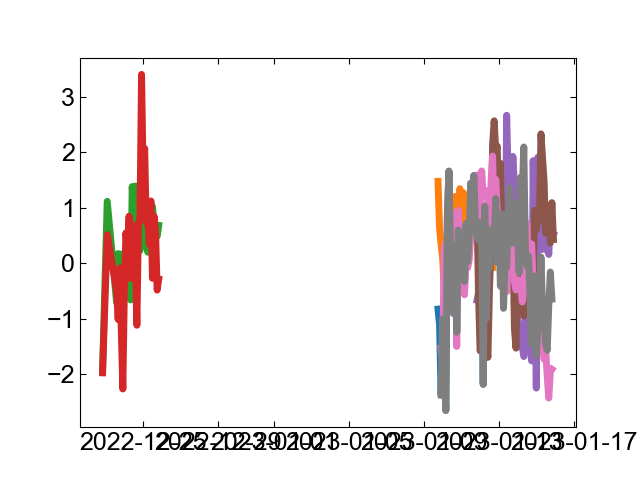

In [372]:
ids = resampled_df['unique_id'].unique()
temp_correlations = []
fig,ax = plt.subplots()

# Compare each signal to every other signal
for i in range(len(ids)):
    for j in range(i+1, len(ids)):
        hyph_i = resampled_df[resampled_df['unique_id'] == ids[i]].set_index('datetime')['signal']
        hyph_j = resampled_df[resampled_df['unique_id'] == ids[j]].set_index('datetime')['signal']

        # Only compare signals over shared time intervals
        common_index = hyph_i.index.intersection(hyph_j.index)
        if len(common_index) < 30:  # At least two points are required to compute correlation
            continue
        else:
            
            
            corr_value = hyph_i[common_index].corr(hyph_j[common_index])
            if corr_value>=0.2:
                # print(ids[i],ids[j])
                ax.plot(common_index,hyph_j[common_index],linewidth = 5)
                ax.plot(common_index,hyph_i[common_index],linewidth = 5)
                
            
            temp_correlations.append(corr_value)
len(temp_correlations)

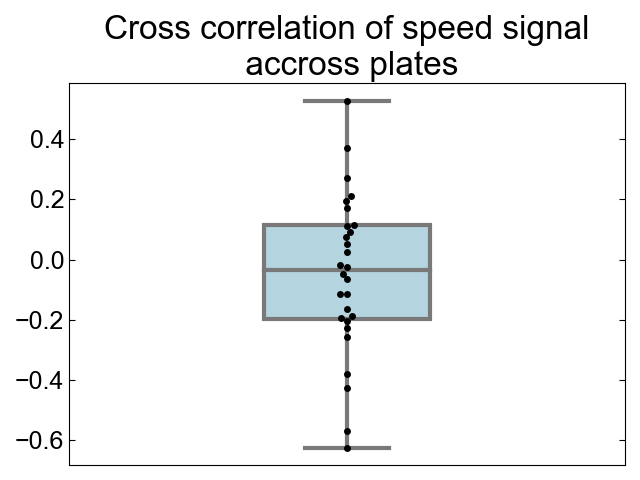

In [375]:
fig,ax = plt.subplots()
data = temp_correlations
sns.boxplot(data=data, color="lightblue", width=0.3)

# Overlay the scatter datapoints
sns.swarmplot(data=data, color="black", size=5)

plt.title("Cross correlation of speed signal\n accross plates")
ax.set_xticks([])

plt.tight_layout()
plt.show()

In [421]:
len(select_width['end'].unique())

345

C:\Users\coren\AppData\Local\Temp\ipykernel_22084\1340645272.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_width['time_bin'] = pd.cut(select_width['time_since_emergence'], bins=num_bins)


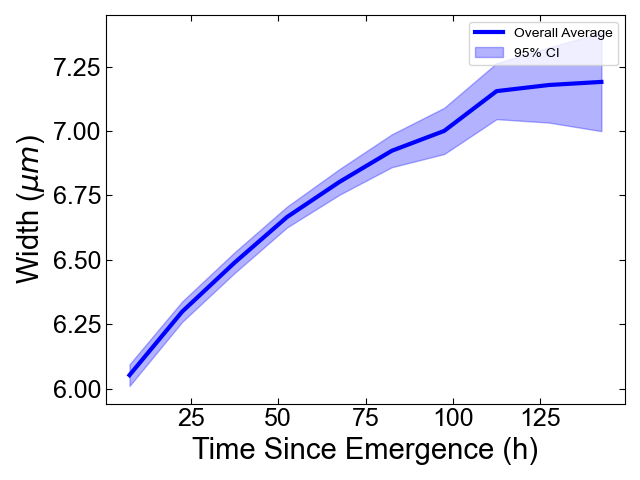

In [427]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# Filter the dataframe for rows where 'av_width' is greater than 0
select_width = select[select['av_width'] > 0]
select_width = select[select['time_since_emergence'] <= 150]


# Number of bins; adjust as needed
num_bins = 10

# Bin the 'time_since_emergence' data into evenly separated intervals
select_width['time_bin'] = pd.cut(select_width['time_since_emergence'], bins=num_bins)

# Compute the mean 'av_width' for each bin
bin_avg = select_width.groupby('time_bin')['av_width'].mean()

# Compute the standard error for 'av_width' for each bin
bin_sem = select_width.groupby('time_bin')['av_width'].sem()

# Compute the 95% confidence intervals
conf_intervals = 1.96 * bin_sem
lower_bound = bin_avg - conf_intervals
upper_bound = bin_avg + conf_intervals

# Plot the binned average 'av_width' against the middle of each 'time_since_emergence' bin with the confidence interval
bin_centers = [interval.mid for interval in bin_avg.index]
ax.plot(bin_centers, bin_avg.values, label='Overall Average', color='blue')
ax.fill_between(bin_centers, lower_bound, upper_bound, color='blue', alpha=0.3, label='95% CI')

ax.set_xlabel('Time Since Emergence (h)')
ax.set_ylabel('Width ($\mu m$)')
ax.legend()
plt.tight_layout()
plt.show()


C:\Users\coren\AppData\Local\Temp\ipykernel_22084\987793968.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_width['time_bin'] = pd.cut(select_width['av_width'], bins=num_bins)


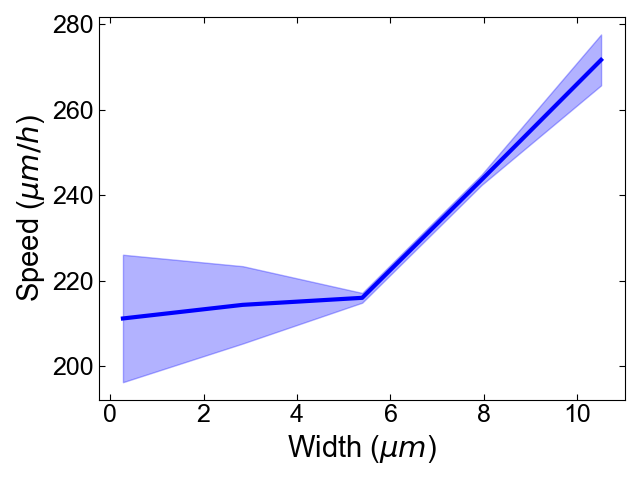

In [432]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# Filter the dataframe for rows where 'av_width' is greater than 0
select_width = select[select['av_width'] > 0]
select_width = select[select['time_since_emergence'] <= 150]


# Number of bins; adjust as needed
num_bins = 5

# Bin the 'time_since_emergence' data into evenly separated intervals
select_width['time_bin'] = pd.cut(select_width['av_width'], bins=num_bins)

# Compute the mean 'av_width' for each bin
bin_avg = select_width.groupby('time_bin')['speed'].mean()

# Compute the standard error for 'av_width' for each bin
bin_sem = select_width.groupby('time_bin')['speed'].sem()

# Compute the 95% confidence intervals
conf_intervals = 1.96 * bin_sem
lower_bound = bin_avg - conf_intervals
upper_bound = bin_avg + conf_intervals

# Plot the binned average 'av_width' against the middle of each 'time_since_emergence' bin with the confidence interval
bin_centers = [interval.mid for interval in bin_avg.index]
ax.plot(bin_centers, bin_avg.values, label='Overall Average', color='blue')
ax.fill_between(bin_centers, lower_bound, upper_bound, color='blue', alpha=0.3, label='95% CI')

ax.set_xlabel('Width ($\mu m$)')
ax.set_ylabel('Speed ($\mu m/h$)')
plt.tight_layout()
plt.show()


In [434]:
len(select_width)

14817

In [414]:
subset.columns

Index(['end', 'pos_x', 'pos_y', 'time_since_begin_exp', 'distance_final_pos',
       'timedelta', 'time_since_emergence', 'speed', 'timestep',
       'timestep_init', 'time_init', 'degree', 'width_tip_edge', 'av_width',
       'has_reached_final_pos', 'in_ROI', 'time_since_begin_h', 'folder',
       'Plate', 'unique_id', 'datetime', 'PrincePos', 'root', 'strain',
       'medium', 'width_root_edge', 'unique_hypha'],
      dtype='object')